In [ ]:
!pip install lightgbm


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
dataset = "/content/drive/MyDrive/Dataset_EEG/eeg_dataset.csv"

In [ ]:
eeg_state = pd.read_csv(dataset)

In [ ]:
eeg_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768000 entries, 0 to 767999
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   F7      768000 non-null  float64
 1   F3      768000 non-null  float64
 2   P7      768000 non-null  float64
 3   O1      768000 non-null  float64
 4   O2      768000 non-null  float64
 5   P8      768000 non-null  float64
 6   AF4     768000 non-null  float64
 7   state   768000 non-null  object 
dtypes: float64(7), object(1)
memory usage: 46.9+ MB


In [ ]:
eeg_state = eeg_state.reset_index(drop=True)

In [ ]:
eeg_state['state'].value_counts()

,count
state,
focussed,384000
unfocussed,384000


In [ ]:
eeg_state['state'].value_counts()

,count
state,
focussed,384000
unfocussed,384000


In [ ]:
eeg_state.to_csv("/content/eeg_dataset_new.csv", index=False)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def custom_classification_report(y_true, y_pred, target_names, class_indices):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Initialize lists to store precision, recall, F1-score, and support for each class
    precision = []
    recall = []
    f1_score = []
    support = []

    # Calculate precision, recall, F1-score for each class
    for i in range(len(target_names)):
        true_positives = cm[i, i]
        false_positives = cm[:, i].sum() - true_positives
        false_negatives = cm[i, :].sum() - true_positives
        true_negatives = cm.sum() - (true_positives + false_positives + false_negatives)

        # Precision: TP / (TP + FP)
        if true_positives + false_positives > 0:
            precision_i = true_positives / (true_positives + false_positives)
        else:
            precision_i = 0.0

        # Recall: TP / (TP + FN)
        if true_positives + false_negatives > 0:
            recall_i = true_positives / (true_positives + false_negatives)
        else:
            recall_i = 0.0

        # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
        if precision_i + recall_i > 0:
            f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
        else:
            f1_i = 0.0

        # Support: The number of true instances of each class
        support_i = cm[i, :].sum()

        # Append calculated metrics for this class
        precision.append(precision_i)
        recall.append(recall_i)
        f1_score.append(f1_i)
        support.append(support_i)

    # Calculate accuracy
    accuracy = np.trace(cm) / np.sum(cm)

    # Calculate average F1-score for specified classes
    f1_average = np.mean([f1_score[i] for i in class_indices])

    # Print the aesthetically improved report
    print("\n" + "Classification Report".center(65, "="))
    print(f"{'Class':<15}{'Precision':>12}{'Recall':>12}{'F1-Score':>12}{'Support':>12}")
    print("=" * 65)
    for i, label in enumerate(target_names):
        print(f"{label:<15}{precision[i]:>12.4f}{recall[i]:>12.4f}{f1_score[i]:>12.4f}{support[i]:>12}")
    print("=" * 65)
    print(f"Average F1-Score for classes : {f1_average:.4f}")
    print("=" * 65)

class_indices = [0, 1]


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Handle missing values
eeg_state = eeg_state.dropna()

# Encode the 'state' column
le = LabelEncoder()
eeg_state['state'] = le.fit_transform(eeg_state['state'])

# Features and target
X = eeg_state.drop('state', axis=1)
y = eeg_state['state']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': 2,  # number of classes
    'learning_rate': 0.1,
    'num_iterations': 700,
    'max_depth': 8,
    'random_seed': 42,
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

# Create dataset for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train the model
lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],

)

# Predict the class labels
y_pred = lgb_model.predict(X_test)

# Convert probabilities to predicted class labels
y_pred_class = np.argmax(y_pred, axis=1)


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 614400, number of used features: 7
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -0.693147


In [ ]:
import joblib
# save model
joblib.dump(lgb_model, '/content/drive/MyDrive/Dataset_EEG/lgbEEG.pkl')

In [ ]:
# Example usage with y_test and y_pred
custom_classification_report(y_test, y_pred_class, target_names=le.classes_, class_indices=class_indices)


======================Classification Report======================
Class             Precision      Recall    F1-Score     Support
0                    0.8567      0.8758      0.8661       76800
1                    0.8729      0.8535      0.8631       76800
Accuracy:    0.8646
Average F1-Score for classes : 0.8646


<ipython-input-122-07ba67f731b1>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


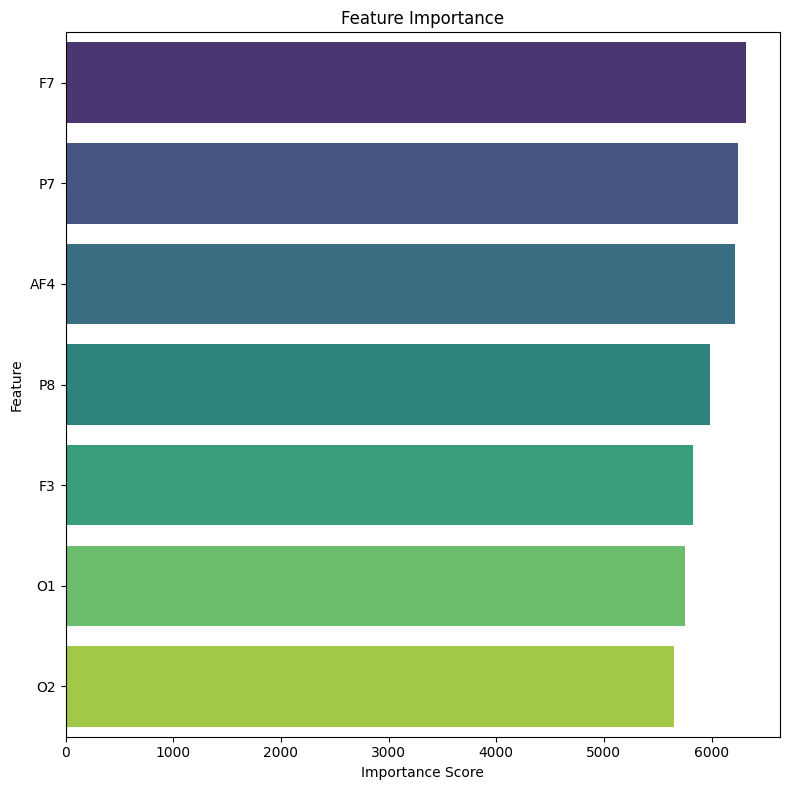

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Get feature names
feature_names = X.columns

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgb_model.feature_importance()
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set up the plot
plt.figure(figsize=(8, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

# Add labels and title
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
test_path = "/content/drive/MyDrive/Dataset_EEG/eeg_dataset.csv"
data = pd.read_csv(test_path)

# Load the pre-trained model
gbm_pickle = joblib.load('/content/drive/MyDrive/Dataset_EEG/lgbEEG.pkl')

# Encode the 'state' column
label_encoder = LabelEncoder()
data['state'] = label_encoder.fit_transform(data['state'])

# Prepare your data
X = data.drop('state', axis=1)  # Drop the label column
y = data['state']  # Use the encoded labels

# Make predictions (for binary classification)
predictions = gbm_pickle.predict(X)  # This gives predicted class labels
predictions = np.argmax(predictions, axis=1)
# Evaluate the model
class_indices = target_names = [0, 1]


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768000 entries, 0 to 767999
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   F7      768000 non-null  float64
 1   F3      768000 non-null  float64
 2   P7      768000 non-null  float64
 3   O1      768000 non-null  float64
 4   O2      768000 non-null  float64
 5   P8      768000 non-null  float64
 6   AF4     768000 non-null  float64
 7   state   768000 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 46.9 MB


In [ ]:
custom_classification_report(y, predictions, class_indices,target_names)


======================Classification Report======================
Class             Precision      Recall    F1-Score     Support
0                    0.8635      0.8819      0.8726      384000
1                    0.8793      0.8605      0.8698      384000
Average F1-Score for classes : 0.8712


In [ ]:
import pygame
import sys
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# Initialize Pygame
pygame.init()

# Screen setup
WIDTH, HEIGHT = 800, 600
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("EEG State Predictor Game")

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)

# Fonts
font = pygame.font.Font(None, 36)

# Load the dataset and model
test_path = "/content/drive/MyDrive/Dataset_EEG/eeg_dataset.csv"
data = pd.read_csv(test_path)

# Load the pre-trained model
gbm_pickle = joblib.load('/content/drive/MyDrive/Dataset_EEG/lgbEEG.pkl')

# Encode the 'state' column
label_encoder = LabelEncoder()
data['state'] = label_encoder.fit_transform(data['state'])

# Prepare your data
X = data.drop('state', axis=1)  # Drop the label column
y = data['state']  # Use the encoded labels

# Make predictions
predictions = np.argmax(gbm_pickle.predict(X),axis = 1)  # This gives predicted class labels
predicted_states = label_encoder.inverse_transform(predictions)  # Convert back to original labels

# Game setup
current_state = 0
guess = None
real_state = None

# Main game loop
clock = pygame.time.Clock()
running = True

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            if current_state < len(predicted_states):
                mouse_pos = pygame.mouse.get_pos()
                # Simple button guess
                if mouse_pos[0] < WIDTH // 2:
                    guess = 0  # Guess state 1
                else:
                    guess = 1  # Guess state 2
                real_state = predicted_states[current_state]
                current_state += 1

    screen.fill(WHITE)

    # Game logic
    if guess is not None and real_state is not None:
        result_text = f"Your guess: {guess + 1}"
        actual_text = f"Actual state: {real_state}"
        result_color = GREEN if (guess == int(real_state) - 1) else RED
        screen.blit(font.render(result_text, True, BLACK), (50, 200))
        screen.blit(font.render(actual_text, True, BLACK), (50, 250))
        pygame.draw.rect(screen, result_color, (50, 300, 200, 50))

    else:
        prompt = font.render("Click Left or Right to guess the state!", True, BLACK)
        screen.blit(prompt, (WIDTH // 2 - prompt.get_width() // 2, HEIGHT // 2 - prompt.get_height() // 2))

    pygame.display.flip()
    clock.tick(60)

pygame.quit()
sys.exit()


KeyboardInterrupt: 

In [ ]:
import pygame
import sys
import random
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder

# Initialize Pygame
pygame.init()

# Screen setup
WIDTH, HEIGHT = 800, 600
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("EEG State Predictor Game")

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)

# Fonts
font = pygame.font.Font(None, 36)

# Load the model (adjust the path as needed)
model = joblib.load('/content/drive/MyDrive/Dataset_EEG/lgbEEG.pkl')

# Define your data for label encoding (ensure this is correct)
data = ...  # Load your data here
label_encoder = LabelEncoder()
label_encoder.fit(data['state'])  # Replace with your actual state names

# EEG Wave Simulation
class EEGWave:
    def __init__(self, color):
        self.color = color
        self.points = [(0, HEIGHT // 2)]
        self.max_points = WIDTH

    def update(self):
        if len(self.points) >= self.max_points:
            self.points.pop(0)
        new_y = self.points[-1][1] + random.randint(-5, 5)
        new_y = max(min(new_y, HEIGHT - 10), 10)  # Keep within screen bounds
        self.points.append((self.points[-1][0] + 1, new_y))

    def draw(self, surface):
        if len(self.points) > 1:
            pygame.draw.lines(surface, self.color, False, self.points, 2)

# Game states
SIMULATING = 0
GUESSING = 1
RESULT = 2

# Game setup
eeg_waves = [EEGWave(RED), EEGWave(GREEN), EEGWave(BLUE)]
current_state = SIMULATING
simulation_time = 0
guess_buttons = [
    pygame.Rect(WIDTH // 4 - 100, HEIGHT - 100, 200, 50),
    pygame.Rect(3 * WIDTH // 4 - 100, HEIGHT - 100, 200, 50)
]
guess = None
real_state = None
prediction = None

# Main game loop
clock = pygame.time.Clock()
running = True

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN and current_state == GUESSING:
            mouse_pos = pygame.mouse.get_pos()
            for i, button in enumerate(guess_buttons):
                if button.collidepoint(mouse_pos):
                    guess = i
                    current_state = RESULT

    screen.fill(WHITE)

    if current_state == SIMULATING:
        simulation_time += 1
        for wave in eeg_waves:
            wave.update()
            wave.draw(screen)

        if simulation_time >= 300:  # Simulate for 5 seconds (60 FPS * 5)
            current_state = GUESSING
            # Generate 'real' state and model prediction
            features = [wave.points[-1][1] for wave in eeg_waves]
            X = np.array(features).reshape(1, -1)
            prediction = model.predict(X)
            real_state = np.argmax(prediction)  # Adjust if model output is not probabilities

    elif current_state == GUESSING:
        for wave in eeg_waves:
            wave.draw(screen)

        for i, button in enumerate(guess_buttons):
            pygame.draw.rect(screen, BLACK, button, 2)
            text = font.render(f"State {i+1}", True, BLACK)
            text_rect = text.get_rect(center=button.center)
            screen.blit(text, text_rect)

        prompt = font.render("Guess the EEG state:", True, BLACK)
        screen.blit(prompt, (WIDTH // 2 - prompt.get_width() // 2, HEIGHT - 150))

    elif current_state == RESULT:
        result_text = f"Your guess: State {guess + 1}" if guess is not None else "No guess made."
        real_text = f"Actual state: State {real_state + 1}" if real_state is not None else "No state available."
        prediction_text = f"Model prediction: State {np.argmax(prediction) + 1}" if prediction is not None else "No prediction made."

        screen.blit(font.render(result_text, True, BLACK), (50, 200))
        screen.blit(font.render(real_text, True, BLACK), (50, 250))
        screen.blit(font.render(prediction_text, True, BLACK), (50, 300))

        if guess == real_state:
            screen.blit(font.render("Correct guess!", True, GREEN), (50, 350))
        else:
            screen.blit(font.render("Incorrect guess.", True, RED), (50, 350))

        # Reset button
        reset_button = pygame.Rect(WIDTH // 2 - 100, HEIGHT - 100, 200, 50)
        pygame.draw.rect(screen, BLACK, reset_button, 2)
        reset_text = font.render("Play Again", True, BLACK)
        reset_text_rect = reset_text.get_rect(center=reset_button.center)
        screen.blit(reset_text, reset_text_rect)

        # Check for reset
        if event.type == pygame.MOUSEBUTTONDOWN and reset_button.collidepoint(pygame.mouse.get_pos()):
            current_state = SIMULATING
            simulation_time = 0
            eeg_waves = [EEGWave(RED), EEGWave(GREEN), EEGWave(BLUE)]
            guess = None
            real_state = None
            prediction = None

    pygame.display.flip()
    clock.tick(60)

pygame.quit()
sys.exit()


TypeError: 'ellipsis' object is not subscriptable